In [2]:
library(ggplot2)
theme_set(
  theme_bw() +
    theme(legend.position = "top")
  )
mynamestheme <- theme(plot.title = element_text(family = "Helvetica", face = "bold", size = (15)), 
                 legend.title = element_text(colour = "steelblue",  face = "bold.italic", family = "Helvetica"), 
                 legend.text = element_text(face = "italic", colour="steelblue4",family = "Helvetica"), 
                  axis.title = element_text(family = "Helvetica", size = (10), colour = "steelblue4"),
                  axis.text = element_text(family = "Courier", colour = "cornflowerblue", size = (10)))
library(gridExtra)

In [3]:
# install.packages("mice")
# install.packages("VIM")
# install.packages("alookr")
# install.packages("visreg")
# install.packages("confidence")
# install.packages("randomForestExplainer")

In [4]:
# Download R libraries for visualization analysis
library(visreg)
library(RColorBrewer)
library(confidence)
library(randomForest)
library(randomForestExplainer)

Loading required package: tcltk


For more information on the usage of the Confidence tool, type:
vignette("confidence")
Examples of input files can be found in:
‘/Library/Frameworks/R.framework/Versions/4.0/Resources/library/confidence/extdata’

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [5]:
# Download R libraries for analysis
library(xts)
library(dplyr)
library(broom)
library(quantmod)
library(lubridate)
library(mice)
library(VIM)
library(reshape2)
library(glmnet)
library(alookr)
library(magrittr)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following object is masked from ‘package:randomForest’:

    combine


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects 

In [6]:
debug_contr_error <- function (dat, subset_vec = NULL) {
  if (!is.null(subset_vec)) {
    ## step 0
    if (mode(subset_vec) == "logical") {
      if (length(subset_vec) != nrow(dat)) {
        stop("'logical' `subset_vec` provided but length does not match `nrow(dat)`")
        }
      subset_log_vec <- subset_vec
      } else if (mode(subset_vec) == "numeric") {
      ## check range
      ran <- range(subset_vec)
      if (ran[1] < 1 || ran[2] > nrow(dat)) {
        stop("'numeric' `subset_vec` provided but values are out of bound")
        } else {
        subset_log_vec <- logical(nrow(dat))
        subset_log_vec[as.integer(subset_vec)] <- TRUE
        } 
      } else {
      stop("`subset_vec` must be either 'logical' or 'numeric'")
      }
    dat <- base::subset(dat, subset = subset_log_vec)
    } else {
    ## step 1
    dat <- stats::na.omit(dat)
    }
  if (nrow(dat) == 0L) warning("no complete cases")
    ## step 2
  var_mode <- sapply(dat, mode)
  if (any(var_mode %in% c("complex", "raw"))) stop("complex or raw not allowed!")
  var_class <- sapply(dat, class)
  if (any(var_mode[var_class == "AsIs"] %in% c("logical", "character"))) {
    stop("matrix variables with 'AsIs' class must be 'numeric'")
    }
  ind1 <- which(var_mode %in% c("logical", "character"))
  dat[ind1] <- lapply(dat[ind1], as.factor)
  ## step 3
  fctr <- which(sapply(dat, is.factor))
  if (length(fctr) == 0L) warning("no factor variables to summary")
  ind2 <- if (length(ind1) > 0L) fctr[-ind1] else fctr
  dat[ind2] <- lapply(dat[ind2], base::droplevels.factor)
  ## step 4
  lev <- lapply(dat[fctr], base::levels.default)
  nl <- lengths(lev)
  ## return
  list(nlevels = nl, levels = lev)
  }

In [7]:
# Read Data
house.data <- read.csv("data/train.csv", stringsAsFactors=TRUE)
str(house.data)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..:

# Data Exploration

NULL


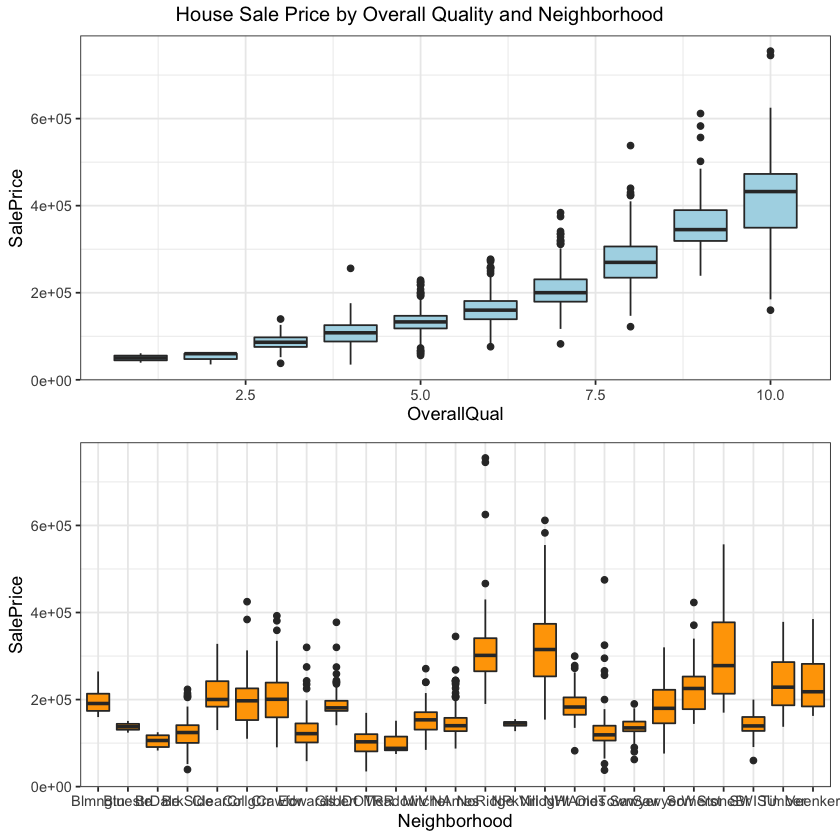

In [8]:
house_g1 <- ggplot(house.data, aes(x=OverallQual, , y=SalePrice, group=OverallQual)) + geom_boxplot(fill="lightblue")
house_g2 <- ggplot(house.data, aes(x=Neighborhood, , y=SalePrice, group=Neighborhood)) + geom_boxplot(fill="orange")

housePrice_plot <- grid.arrange(house_g1, house_g2, top = "House Sale Price by Overall Quality and Neighborhood", nrow = 2)
print(housePrice_plot + mynamestheme )

In [9]:
summary(house.data$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  129975  163000  180921  214000  755000 

## DATA CLEANING
* MCAR: missing completely at random. This is the desirable scenario in case of missing data.
* MNAR: missing not at random. Missing not at random data is a more serious issue and in this case it might be wise to check the data gathering process further and try to understand why the information is missing.

In [10]:
sum(is.na(house.data$GarageYrBlt))
which(is.na(house.data$GarageYrBlt))

[1] 81

[1]   40   49   79   89   90  100  109  126  128  141  149  156  164  166  199
[16]  211  242  251  288  292  308  376  387  394  432  435  442  465  496  521
[31]  529  534  536  563  583  614  615  621  636  637  639  650  706  711  739
[46]  751  785  827  844  922  943  955  961  969  971  977 1010 1012 1031 1039
[61] 1097 1124 1132 1138 1144 1174 1180 1219 1220 1235 1258 1284 1324 1326 1327
[76] 1338 1350 1408 1450 1451 1454

In [11]:
# Find the number of missing values
apply(is.na(house.data), 2, sum)

Id    MSSubClass      MSZoning   LotFrontage       LotArea 
            0             0             0           259             0 
       Street         Alley      LotShape   LandContour     Utilities 
            0          1369             0             0             0 
    LotConfig     LandSlope  Neighborhood    Condition1    Condition2 
            0             0             0             0             0 
     BldgType    HouseStyle   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd     RoofStyle      RoofMatl   Exterior1st   Exterior2nd 
            0             0             0             0             0 
   MasVnrType    MasVnrArea     ExterQual     ExterCond    Foundation 
            8             8             0             0             0 
     BsmtQual      BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1 
           37            37            38            37             0 
 BsmtFinType2    BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating 
           38             0             0             0             0 
    HeatingQC    CentralAir    Electrical     X1stFlrSF     X2ndFlrSF 
            0             0             1             0             0 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
            0             0             0             0             0 
     HalfBath  BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd 
            0             0             0             0             0 
   Functional    Fireplaces   FireplaceQu    GarageType   GarageYrBlt 
            0             0           690            81            81 
 GarageFinish    GarageCars    GarageArea    GarageQual    GarageCond 
           81             0             0            81            81 
   PavedDrive    WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch 
            0             0             0             0             0 
  ScreenPorch      PoolArea        PoolQC         Fence   MiscFeature 
            0             0          1453          1179          1406 
      MiscVal        MoSold        YrSold      SaleType SaleCondition 
            0             0             0             0             0 
    SalePrice 
            0

In [12]:
# Find percentage of missing values in each column (safe maximum threshold is 5% of the total for large datasets)
# apply(is.na(house.data), 2, mean)
pMiss <- function(x){sum(is.na(x))/length(x)*100}
apply(house.data,2,pMiss)
# apply(house.data,1,pMiss)

Id    MSSubClass      MSZoning   LotFrontage       LotArea 
   0.00000000    0.00000000    0.00000000   17.73972603    0.00000000 
       Street         Alley      LotShape   LandContour     Utilities 
   0.00000000   93.76712329    0.00000000    0.00000000    0.00000000 
    LotConfig     LandSlope  Neighborhood    Condition1    Condition2 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
     BldgType    HouseStyle   OverallQual   OverallCond     YearBuilt 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
 YearRemodAdd     RoofStyle      RoofMatl   Exterior1st   Exterior2nd 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
   MasVnrType    MasVnrArea     ExterQual     ExterCond    Foundation 
   0.54794521    0.54794521    0.00000000    0.00000000    0.00000000 
     BsmtQual      BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1 
   2.53424658    2.53424658    2.60273973    2.53424658    0.00000000 
 BsmtFinType2    BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating 
   2.60273973    0.00000000    0.00000000    0.00000000    0.00000000 
    HeatingQC    CentralAir    Electrical     X1stFlrSF     X2ndFlrSF 
   0.00000000    0.00000000    0.06849315    0.00000000    0.00000000 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
     HalfBath  BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
   Functional    Fireplaces   FireplaceQu    GarageType   GarageYrBlt 
   0.00000000    0.00000000   47.26027397    5.54794521    5.54794521 
 GarageFinish    GarageCars    GarageArea    GarageQual    GarageCond 
   5.54794521    0.00000000    0.00000000    5.54794521    5.54794521 
   PavedDrive    WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
  ScreenPorch      PoolArea        PoolQC         Fence   MiscFeature 
   0.00000000    0.00000000   99.52054795   80.75342466   96.30136986 
      MiscVal        MoSold        YrSold      SaleType SaleCondition 
   0.00000000    0.00000000    0.00000000    0.00000000    0.00000000 
    SalePrice 
   0.00000000

In [13]:
# List of Columns Names with Missing Values
col.missNames = names(which(sapply(house.data, anyNA)))
col.missNames

[1] "LotFrontage"  "Alley"        "MasVnrType"   "MasVnrArea"   "BsmtQual"    
 [6] "BsmtCond"     "BsmtExposure" "BsmtFinType1" "BsmtFinType2" "Electrical"  
[11] "FireplaceQu"  "GarageType"   "GarageYrBlt"  "GarageFinish" "GarageQual"  
[16] "GarageCond"   "PoolQC"       "Fence"        "MiscFeature"

In [14]:
house.dataMisssedvalues = house.data[,c(col.missNames)]
str(house.dataMisssedvalues)

'data.frame':	1460 obs. of  19 variables:
 $ LotFrontage : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ Alley       : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ MasVnrType  : Factor w/ 4 levels "BrkCmn","BrkFace",..: 2 3 2 3 2 3 4 4 3 3 ...
 $ MasVnrArea  : int  196 0 162 0 350 0 186 240 0 0 ...
 $ BsmtQual    : Factor w/ 4 levels "Ex","Fa","Gd",..: 3 3 3 4 3 3 1 3 4 4 ...
 $ BsmtCond    : Factor w/ 4 levels "Fa","Gd","Po",..: 4 4 4 2 4 4 4 4 4 4 ...
 $ BsmtExposure: Factor w/ 4 levels "Av","Gd","Mn",..: 4 2 3 4 1 4 1 3 4 4 ...
 $ BsmtFinType1: Factor w/ 6 levels "ALQ","BLQ","GLQ",..: 3 1 3 1 3 3 3 1 6 3 ...
 $ BsmtFinType2: Factor w/ 6 levels "ALQ","BLQ","GLQ",..: 6 6 6 6 6 6 6 2 6 6 ...
 $ Electrical  : Factor w/ 5 levels "FuseA","FuseF",..: 5 5 5 5 5 5 5 5 2 5 ...
 $ FireplaceQu : Factor w/ 5 levels "Ex","Fa","Gd",..: NA 5 5 3 5 NA 3 5 5 5 ...
 $ GarageType  : Factor w/ 6 levels "2Types","Attchd",..: 2 2 2 6 2 2 2 2 6 2 ...
 $ GarageYrBlt : int  2003 1976 20

In [15]:
col.delNames = c('PoolQC', 'MiscFeature', 'Fence', 'Alley')
col.delNames

[1] "PoolQC"      "MiscFeature" "Fence"       "Alley"

In [16]:
# Replacing missing values with a value NAN as an additional level of the factor
for (i in col.missNames){
    data_class <- class(house.data[[i]])
    if (data_class == 'factor') {
        # Get levels and add "None"
        levels <- levels(house.data[[i]])
        # print(i)
        # print(levels)
        levels[length(levels) + 1] <- "NAN"
        # refactor Species to include "None" as a factor level
        # and replace NA with "None"
        house.data[[i]] <- factor(house.data[[i]], levels = levels)
        house.data[[i]][is.na(house.data[[i]])] <- "NAN"
       
   }
    else if (data_class == 'integer') {
        house.data[[i]] <- ifelse(is.na(house.data[[i]]), mean(house.data[[i]], na.rm=TRUE), house.data[[i]])
        house.data[[i]] <- round(house.data[[i]], digits = 0)
    }
}

In [17]:
# Find the number of missing values
apply(is.na(house.data), 2, sum)

Id    MSSubClass      MSZoning   LotFrontage       LotArea 
            0             0             0             0             0 
       Street         Alley      LotShape   LandContour     Utilities 
            0             0             0             0             0 
    LotConfig     LandSlope  Neighborhood    Condition1    Condition2 
            0             0             0             0             0 
     BldgType    HouseStyle   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd     RoofStyle      RoofMatl   Exterior1st   Exterior2nd 
            0             0             0             0             0 
   MasVnrType    MasVnrArea     ExterQual     ExterCond    Foundation 
            0             0             0             0             0 
     BsmtQual      BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1 
            0             0             0             0             0 
 BsmtFinType2    BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating 
            0             0             0             0             0 
    HeatingQC    CentralAir    Electrical     X1stFlrSF     X2ndFlrSF 
            0             0             0             0             0 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
            0             0             0             0             0 
     HalfBath  BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd 
            0             0             0             0             0 
   Functional    Fireplaces   FireplaceQu    GarageType   GarageYrBlt 
            0             0             0             0             0 
 GarageFinish    GarageCars    GarageArea    GarageQual    GarageCond 
            0             0             0             0             0 
   PavedDrive    WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch 
            0             0             0             0             0 
  ScreenPorch      PoolArea        PoolQC         Fence   MiscFeature 
            0             0             0             0             0 
      MiscVal        MoSold        YrSold      SaleType SaleCondition 
            0             0             0             0             0 
    SalePrice 
            0

In [18]:
# md.pattern(house.dataMisssedvalues)

Warning message in plot.aggr(res, ...):
“not enough vertical space to display frequencies (too many combinations)”



 Variables sorted by number of missings: 
     Variable        Count
       PoolQC 0.9952054795
  MiscFeature 0.9630136986
        Alley 0.9376712329
        Fence 0.8075342466
  FireplaceQu 0.4726027397
  LotFrontage 0.1773972603
   GarageType 0.0554794521
  GarageYrBlt 0.0554794521
 GarageFinish 0.0554794521
   GarageQual 0.0554794521
   GarageCond 0.0554794521
 BsmtExposure 0.0260273973
 BsmtFinType2 0.0260273973
     BsmtQual 0.0253424658
     BsmtCond 0.0253424658
 BsmtFinType1 0.0253424658
   MasVnrType 0.0054794521
   MasVnrArea 0.0054794521
   Electrical 0.0006849315


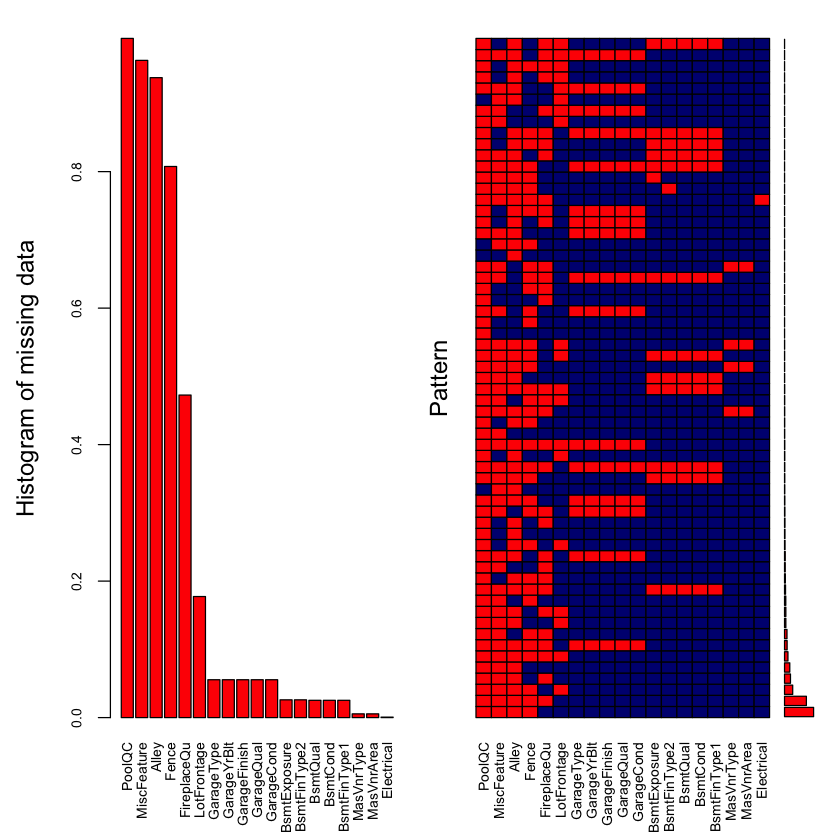

In [19]:
aggr_plot <- aggr(house.dataMisssedvalues, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(data), 
                  cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

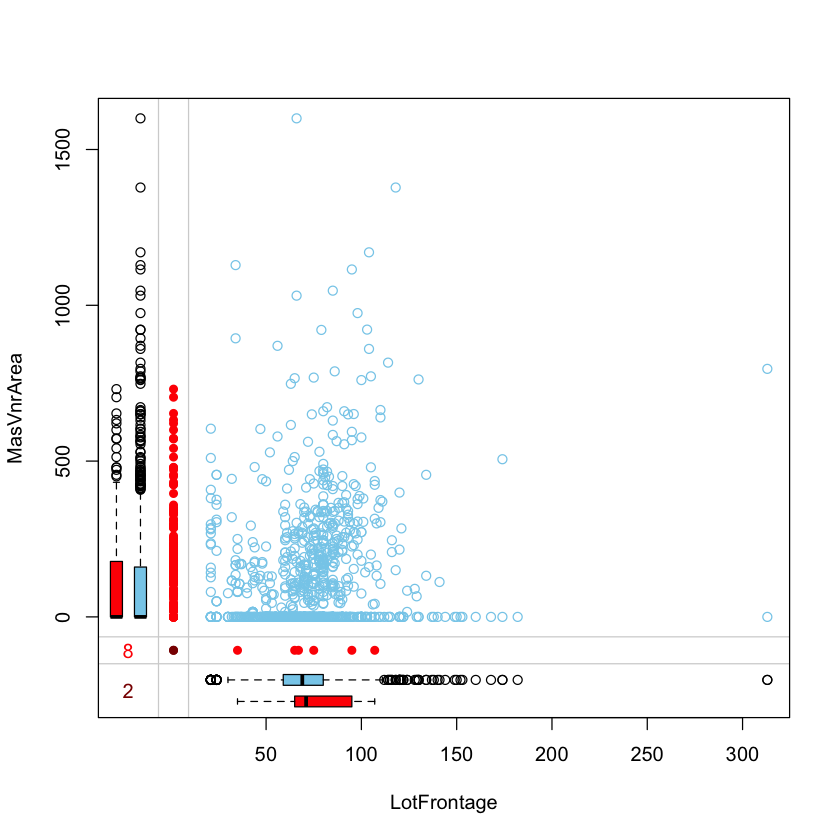

In [20]:
marginplot(house.dataMisssedvalues[c(1,4)])

In [21]:
# Imputing missing values
# tempData <- mice(house.dataMisssedvalues,m=5,maxit=50,meth='pmm',seed=500)
# summary(tempData)

In [22]:
# xyplot(tempData,LotFrontage ~ MasVnrArea+GarageType+GarageYrBlt,pch=18,cex=1)
# densityplot(tempData)
# stripplot(tempData, pch = 20, cex = 1.2)

In [23]:
# Create Clean Data Frame without Columns with Missing Values
house.dataClean <- house.data[, setdiff(names(house.data), c(col.delNames, 'Id', 'Utilities', 'RoofMatl'))]
str(house.dataClean)

'data.frame':	1460 obs. of  74 variables:
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : num  65 80 68 60 84 85 75 70 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..: 6 25 6 7 14 12 21 17 18 4 ...
 $ Condition1   : Factor w/ 9 levels "Artery","Feedr",..: 3 2 3 3 3 3 3 5 1 1 ...
 $ Condition2   : Factor w/ 8 levels "Artery","Feedr",..: 3 3 3 3 3 3 3 3 3 1 ...
 $ BldgType     : F

## Correlation Matrix (numerical variables)

In [24]:
# Selecting only numeric columns from a data frame
house.dataNumeric <- select_if(house.dataClean, is.numeric)

In [25]:
cormat <- round(cor(house.dataNumeric),2)
cormat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.00,-0.36,-0.14,0.03,-0.06,0.03,0.04,0.02,-0.07,-0.07,⋯,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.36,1.00,0.31,0.23,-0.05,0.12,0.08,0.18,0.22,0.04,⋯,0.08,0.14,0.01,0.06,0.04,0.18,0.00,0.01,0.01,0.33
LotArea,-0.14,0.31,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,⋯,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,0.03,0.23,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,⋯,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,-0.06,-0.05,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,⋯,0.00,-0.03,0.07,0.03,0.05,0.00,0.07,0.00,0.04,-0.08
YearBuilt,0.03,0.12,0.01,0.57,-0.38,1.00,0.59,0.31,0.25,-0.05,⋯,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,0.04,0.08,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,⋯,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,0.02,0.18,0.10,0.41,-0.13,0.31,0.18,1.00,0.26,-0.07,⋯,0.16,0.12,-0.11,0.02,0.06,0.01,-0.03,-0.01,-0.01,0.48
BsmtFinSF1,-0.07,0.22,0.21,0.24,-0.05,0.25,0.13,0.26,1.00,-0.05,⋯,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39
BsmtFinSF2,-0.07,0.04,0.11,-0.06,0.04,-0.05,-0.07,-0.07,-0.05,1.00,⋯,0.07,0.00,0.04,-0.03,0.09,0.04,0.00,-0.02,0.03,-0.01


In [26]:
# cormat <- cormat %>% slice(1:12)
melted_cormat <- melt(cormat)
melted_cormat <- melted_cormat %>% slice(1:12)
str(melted_cormat)

'data.frame':	12 obs. of  3 variables:
 $ Var1 : Factor w/ 37 levels "MSSubClass","LotFrontage",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Var2 : Factor w/ 37 levels "MSSubClass","LotFrontage",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ value: num  1 -0.36 -0.14 0.03 -0.06 0.03 0.04 0.02 -0.07 -0.07 ...


In [27]:
# Get lower triangle of the correlation matrix
  get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)
  }
  # Get upper triangle of the correlation matrix
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)

In [28]:
reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd)
cormat <-cormat[hc$order, hc$order]
}
# Reorder the correlation matrix
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)
# Melt the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE)

In [29]:
# write.csv(melted_cormat, file = "data/cor_matrix.csv", fileEncoding = "UTF-8")

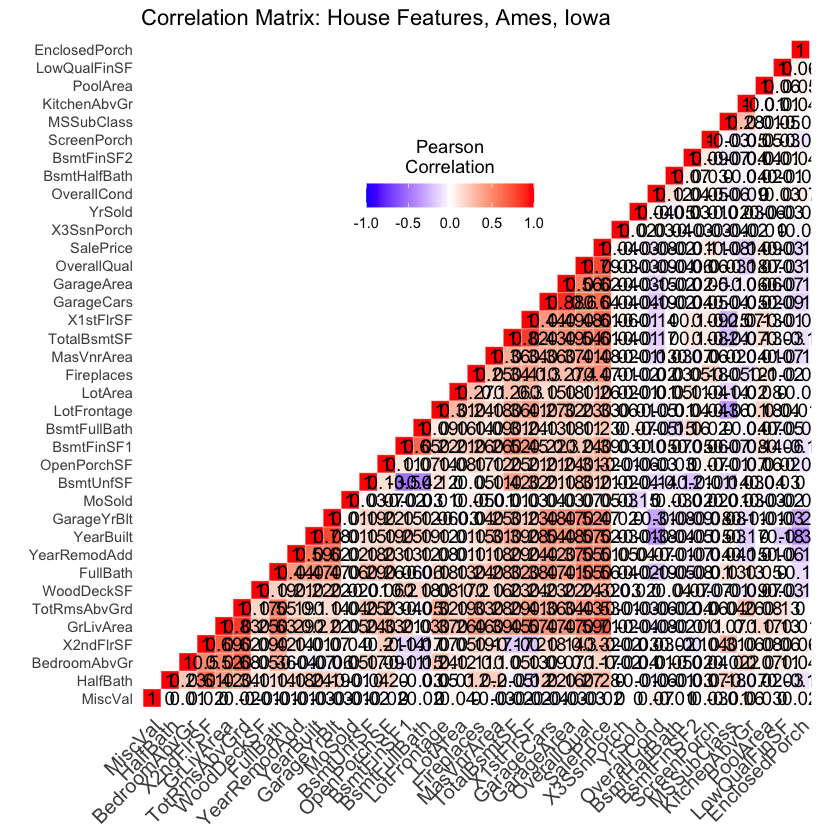

In [30]:
# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()
ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))+ ggtitle("Correlation Matrix: House Features, Ames, Iowa")

## DATA SPLIT SAMPLE.INT

In [31]:
# Split data: training set - 80%, test set - 20%
# set.seed(2)
# housedata.samples <- sample.int(nrow(house.dataClean), 0.8*nrow(house.dataClean))
# train <- house.dataClean[housedata.samples,]
# test <- house.dataClean[-housedata.samples,]
# n <- nrow(train)

In [32]:
# apply(is.na(test), 2, sum)

In [33]:
# apply(is.na(train), 2, sum)

In [34]:
# debug_contr_error(train)

In [35]:
# debug_contr_error(test)

In [36]:
# Build a model without interactions
# base.house.rate <- lm(log(SalePrice) ~ 1, data=train)
# full.house.rate <- lm(log(SalePrice) ~ ., data=train)

In [37]:
# Forward Stepwise Regression
# fwdBIC.base <- step(base.house.rate, scope=formula(full.house.rate),
# direction="forward", k=log(n))
# summary(fwdBIC.base)

In [38]:
# BIC.base = extractAIC(fwdBIC.base, k=log(n))[2]
# signif(BIC.base, digits=6)

In [39]:
# Build a model with all posible interactions
# full_interact.house.rate <- lm(log(SalePrice) ~ . + .^2, data=train)

In [40]:
# Forward Stepwise Regression
# fwdBIC.interact <- step(base.house.rate, scope=formula(full_interact.house.rate),
# direction="forward", k=log(n))
# summary(fwdBIC)

In [41]:
# BIC.interact = extractAIC(fwdBIC.interact, k=log(n))[2]
# signif(BIC.interact, digits=6)

## DATA SPLIT SPLIT_BY

In [42]:
# Generate data for the example
split.data <- house.dataClean %>%
  split_by(SalePrice, seed = 2)

In [43]:
# The attributes of the split_df class are as follows.:
# split_seed : integer. random seed used for splitting
# target : character. the name of the target variable
# binary : logical. whether the target variable is binary class
# minority : character. the name of the minority class
# majority : character. the name of the majority class
# minority_rate : numeric. the rate of the minority class
# majority_rate : numeric. the rate of the majority class

attr_names <- names(attributes(split.data))
attr_names

[1] "names"         "row.names"     "groups"        "class"        
 [5] "split_seed"    "target"        "binary"        "minority"     
 [9] "majority"      "minority_rate" "majority_rate"

In [44]:
split.data_attr <- attributes(split.data)
split.data_attr[!attr_names %in% "row.names"]$names

[1] "MSSubClass"    "MSZoning"      "LotFrontage"   "LotArea"      
 [5] "Street"        "LotShape"      "LandContour"   "LotConfig"    
 [9] "LandSlope"     "Neighborhood"  "Condition1"    "Condition2"   
[13] "BldgType"      "HouseStyle"    "OverallQual"   "OverallCond"  
[17] "YearBuilt"     "YearRemodAdd"  "RoofStyle"     "Exterior1st"  
[21] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[25] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[29] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[33] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[37] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[41] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[45] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[49] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[53] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[57] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[61] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[65] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[69] "MiscVal"       "MoSold"        "YrSold"        "SaleType"     
[73] "SaleCondition" "SalePrice"     "split_flag"

In [45]:
# split.data_attr[!attr_names %in% "row.names"]$groups

In [46]:
# write.csv(split.data, file = "data/cleandata_split.csv", fileEncoding = "UTF-8")

In [47]:
category_data <- split.data %>%
  compare_target_category()

In [48]:
category_data$Type <- 'Factor'

In [49]:
head(category_data)

variable,level,train,test,abs_diff,Type
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>
MSZoning,C (all),0.8814887,0.2277904,0.6536983,Factor
MSZoning,FV,4.5053869,4.3280182,0.1773687,Factor
MSZoning,RH,1.2732615,0.6833713,0.5898902,Factor
MSZoning,RL,78.0607248,80.6378132,2.5770884,Factor
MSZoning,RM,15.2791381,14.1230068,1.1561313,Factor
Street,Grvl,0.5876592,NA,NA,Factor


In [50]:
# write.csv(category_data, file = "data/category_data.csv", fileEncoding = "UTF-8")

In [51]:
numeric_data <- split.data %>%
  compare_target_numeric()

In [52]:
# write.csv(numeric_data, file = "data/numeric_data.csv", fileEncoding = "UTF-8")

In [53]:
# balance variable only
split.data %>%
  compare_target_numeric(YearBuilt)

variable,train_mean,test_mean,train_sd,test_sd,train_z,test_z
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YearBuilt,1971.199,1971.428,30.28454,30.04599,65.08927,65.61369


In [54]:
train_split <- split.data %>%
  extract_set(set = "train")

test_split <- split.data %>%
  extract_set(set = "test")

dim(train_split)
dim(test_split)


[1] 1021   74

[1] 439  74

In [55]:
n <- nrow(train_split)
head(train_split)

MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,⋯,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>
60,RL,65,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,⋯,0,0,0,0,0,2,2008,WD,Normal,208500
20,RL,80,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,⋯,0,0,0,0,0,5,2007,WD,Normal,181500
60,RL,68,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,⋯,0,0,0,0,0,9,2008,WD,Normal,223500
70,RL,60,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,⋯,272,0,0,0,0,2,2006,WD,Abnorml,140000
60,RL,84,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,⋯,0,0,0,0,0,12,2008,WD,Normal,250000
50,RL,85,14115,Pave,IR1,Lvl,Inside,Gtl,Mitchel,⋯,0,320,0,0,700,10,2009,WD,Normal,143000


In [56]:
# debug_contr_error(train_split)

In [57]:
# debug_contr_error(test_split)

## MANUAL REGRESSION MODEL (BASE)

In [58]:
#Manual regular linear model with the selected variables
manual.model <- lm(SalePrice ~ YearBuilt + BldgType + FullBath + GrLivArea + TotRmsAbvGrd + 
                         GarageArea + Neighborhood, data=train_split )
summary(manual.model)


Call:
lm(formula = SalePrice ~ YearBuilt + BldgType + FullBath + GrLivArea + 
    TotRmsAbvGrd + GarageArea + Neighborhood, data = train_split)

Residuals:
    Min      1Q  Median      3Q     Max 
-371810  -17952   -1674   14566  279899 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.288e+06  1.789e+05  -7.200 1.20e-12 ***
YearBuilt            6.930e+02  8.962e+01   7.733 2.59e-14 ***
BldgType2fmCon      -1.508e+04  8.750e+03  -1.723  0.08519 .  
BldgTypeDuplex      -4.069e+04  6.878e+03  -5.915 4.56e-09 ***
BldgTypeTwnhs       -5.431e+04  9.054e+03  -5.998 2.80e-09 ***
BldgTypeTwnhsE      -3.113e+04  6.000e+03  -5.188 2.57e-07 ***
FullBath             5.203e+03  3.412e+03   1.525  0.12763    
GrLivArea            7.384e+01  4.964e+00  14.874  < 2e-16 ***
TotRmsAbvGrd        -2.248e+03  1.459e+03  -1.541  0.12366    
GarageArea           4.617e+01  7.597e+00   6.078 1.74e-09 ***
NeighborhoodBlueste -2.338e+04  2.949e+04  -0.793  0.

In [59]:
BIC.manual = extractAIC(manual.model, k=log(length(train_split$SalePrice)))[2]
signif(BIC.manual, digits=6)

[1] 21718.6

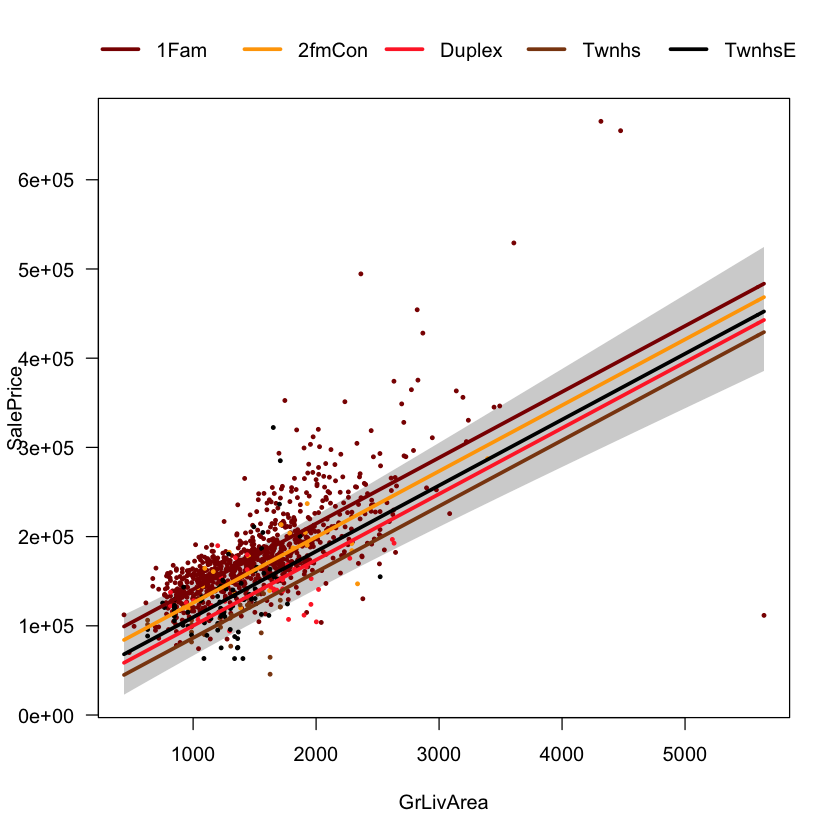

In [60]:
ugly_cols <- c("darkred", "orange", "firebrick1", "chocolate4", "gray0")

visreg(manual.model, "GrLivArea", by="BldgType", overlay=TRUE,
      legend=TRUE, rug=FALSE,
       line.par=list(col=ugly_cols),
       points.par=list(col=ugly_cols),
      fill.par=list(col="lightgrey"))

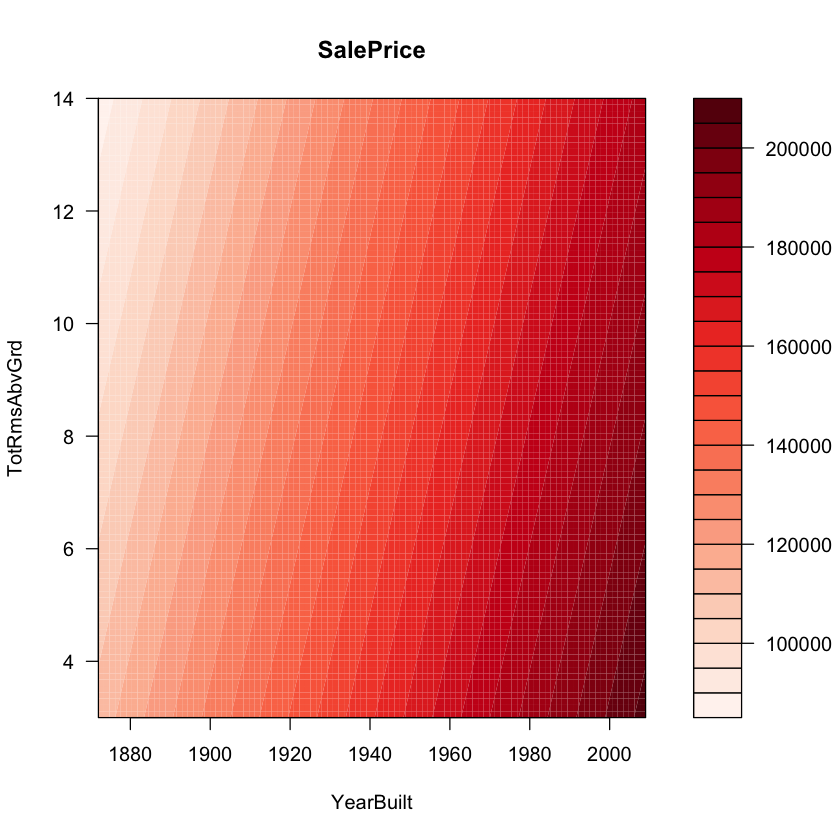

In [61]:
visreg2d(manual.model, "YearBuilt", "TotRmsAbvGrd", plot.type = "image",
        scale = "response",  col = colorRampPalette(brewer.pal(9,"Reds"))(20)) 

In [62]:
# with broom (convert lm result to data frame)
# tidy(manual.model_train, quick = TRUE) # with Dec but without se, t.val, p.val
# tidy(manual.model_train, quick = FALSE) # with se, t.val, p.val but without Dec 
manual.model_sum <- left_join(tidy(manual.model, quick = TRUE),
                tidy(manual.model, quick = FALSE),
                by = c("term", "estimate")) # includes Dec, se ...

In [63]:
# manual.model_sum 

In [64]:
# write.csv(manual.model_sum, file = "data/model_sum.csv", fileEncoding = "UTF-8")

#### train set prediction summary

In [65]:
# Prediction Summary for Manual Model - Train Set
train.predict <- as.matrix(predict(manual.model, newdata=train_split))
manual.model_trainresult <- as.data.frame(train.predict)
names(manual.model_trainresult)[names(manual.model_trainresult) == 'V1'] <- 'train_predict'
manual.model_trainresult$train_actual = train_split$SalePrice
manual.model_trainresult$train_diff = (manual.model_trainresult$train_predict - manual.model_trainresult$train_actual)/manual.model_trainresult$train_actual
head(manual.model_trainresult)
signif(mean(manual.model_trainresult$train_diff), digits=3)

,train_predict,train_actual,train_diff
,<dbl>,<int>,<dbl>
1,218823.0,208500,0.04951061
2,210146.2,181500,0.15783024
3,230315.0,223500,0.03049225
4,197138.0,140000,0.40812846
5,320088.8,250000,0.28035506
6,182127.5,143000,0.27361914


[1] 0.0258

In [66]:
# Calculate Model Error 
errorBIC_manualtrain <- log(predict(manual.model, newdata=train_split))-log(train_split$SalePrice)
errorBIC_manualtrain=mean(errorBIC_manualtrain^2)
signif(errorBIC_manualtrain, digits=3)

[1] 0.0343

#### test set prediction summary

In [67]:
# Prediction Summary for Manual Model - Test Set
test.predict_manual <- as.matrix(predict(manual.model, newdata=test_split))
manual.model_testresult <- as.data.frame(test.predict_manual)
names(manual.model_testresult)[names(manual.model_testresult) == 'V1'] <- 'test_predict'
manual.model_testresult$test_actual = test_split$SalePrice
manual.model_testresult$test_diff = (manual.model_testresult$test_predict - manual.model_testresult$test_actual)/manual.model_testresult$test_actual
head(manual.model_testresult)
signif(mean(manual.model_testresult$test_diff^2), digits=3)

,test_predict,test_actual,test_diff
,<dbl>,<int>,<dbl>
1,240778.9,307000,-0.21570401
2,354216.8,345000,0.02671551
3,220682.8,279500,-0.21043734
4,142653.6,157000,-0.09137812
5,367954.6,325300,0.13112402
6,226007.9,230000,-0.01735698


[1] 0.044

In [68]:
# Calculate Model Error - Test Set
errorBIC_manualtest <- log(predict(manual.model, newdata=test_split))-log(test_split$SalePrice)
errorBIC_manualtest=mean(errorBIC_manualtest^2)
signif(errorBIC_manualtest, digits=3)

[1] 0.0351

## MANUAL REGRESSION MODEL (ADVANCED)

In [69]:
# Features list
split.data_attr[!attr_names %in% "row.names"]$names

[1] "MSSubClass"    "MSZoning"      "LotFrontage"   "LotArea"      
 [5] "Street"        "LotShape"      "LandContour"   "LotConfig"    
 [9] "LandSlope"     "Neighborhood"  "Condition1"    "Condition2"   
[13] "BldgType"      "HouseStyle"    "OverallQual"   "OverallCond"  
[17] "YearBuilt"     "YearRemodAdd"  "RoofStyle"     "Exterior1st"  
[21] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[25] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[29] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[33] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[37] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[41] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[45] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[49] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[53] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[57] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[61] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[65] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[69] "MiscVal"       "MoSold"        "YrSold"        "SaleType"     
[73] "SaleCondition" "SalePrice"     "split_flag"

In [70]:
#Manual regular linear model with the selected variables
manual.model_new <- lm(SalePrice ~ OverallCond + OverallQual + Neighborhood + LotArea + GrLivArea + MSZoning + YearBuilt + 
                       BsmtCond + TotalBsmtSF + Heating + CentralAir + FullBath + HalfBath + KitchenQual + 
                         GarageCars + GarageQual + SaleCondition + BedroomAbvGr, data=train_split )
summary(manual.model_new)


Call:
lm(formula = SalePrice ~ OverallCond + OverallQual + Neighborhood + 
    LotArea + GrLivArea + MSZoning + YearBuilt + BsmtCond + TotalBsmtSF + 
    Heating + CentralAir + FullBath + HalfBath + KitchenQual + 
    GarageCars + GarageQual + SaleCondition + BedroomAbvGr, data = train_split)

Residuals:
    Min      1Q  Median      3Q     Max 
-418268  -13049       0   11788  235353 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -6.771e+05  1.871e+05  -3.620 0.000310 ***
OverallCond           7.583e+03  1.164e+03   6.513 1.19e-10 ***
OverallQual           1.235e+04  1.410e+03   8.765  < 2e-16 ***
NeighborhoodBlueste   4.245e+03  2.570e+04   0.165 0.868838    
NeighborhoodBrDale    1.164e+04  1.602e+04   0.727 0.467682    
NeighborhoodBrkSide   3.256e+04  1.319e+04   2.469 0.013709 *  
NeighborhoodClearCr   3.243e+04  1.349e+04   2.404 0.016413 *  
NeighborhoodCollgCr   2.425e+04  1.050e+04   2.310 0.021106 *  
NeighborhoodCrawfor 

In [71]:
BIC.manual = extractAIC(manual.model_new, k=log(length(train_split$SalePrice)))[2]
signif(BIC.manual, digits=6)

[1] 21555.4

## LASSO MODEL

In [72]:
# Loading the data
x_train <- model.matrix(SalePrice~. , train_split)[,-1]
y_train <- train_split$SalePrice
x_test <- model.matrix(SalePrice~. , test_split)[,-1]
y_test <- test_split$SalePrice
lambda_seq <- 10^seq(2, -2, by = -.1)

In [73]:
lasso.fit <- cv.glmnet(x_train, y_train, alpha = 1, lambda = lambda_seq, family="gaussian", standardize = FALSE, nfolds = 5)
                       # family="gaussian", alpha=1, standardize=FALSE)

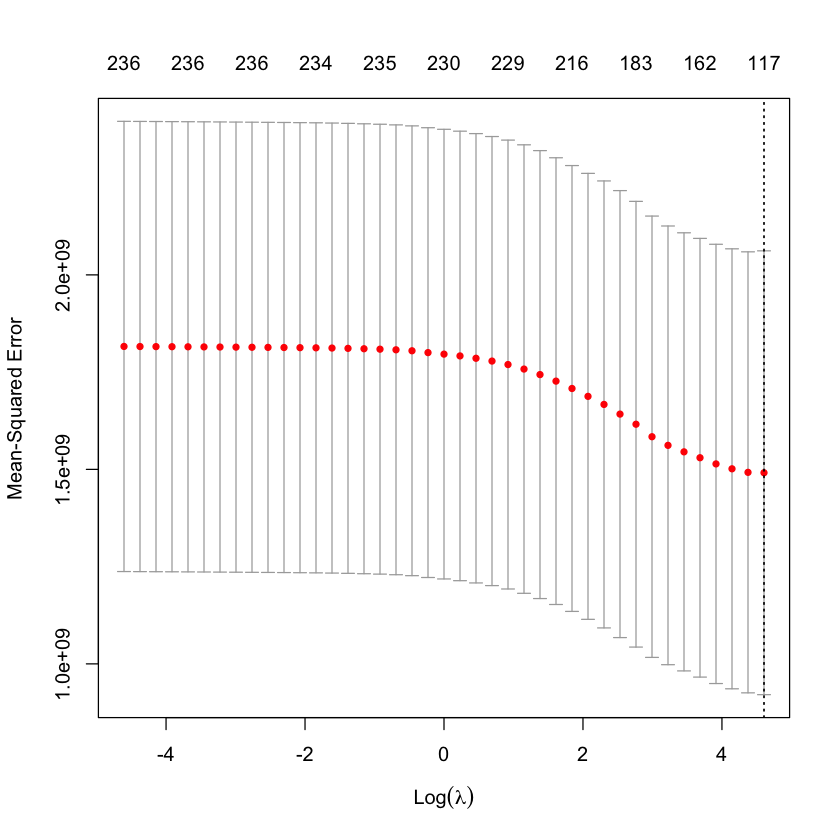

In [74]:
plot(lasso.fit) 

In [75]:
# identifying best lamda
lambda_best <- lasso.fit$lambda.min
betas <- coef(lasso.fit, s = "lambda.1se")
model <- which(betas[2:length(betas)]!=0)

In [76]:
lambda_best

[1] 100

In [77]:
#These are the names of the variables selected
select_features <- colnames(x_train)[model]
select_features

[1] "MSSubClass"          "MSZoningFV"          "MSZoningRL"         
  [4] "LotFrontage"         "LotArea"             "StreetPave"         
  [7] "LotShapeIR2"         "LotShapeIR3"         "LotShapeReg"        
 [10] "LandContourHLS"      "LandContourLow"      "LandContourLvl"     
 [13] "LotConfigCulDSac"    "LotConfigFR2"        "LotConfigInside"    
 [16] "LandSlopeMod"        "LandSlopeSev"        "NeighborhoodBrkSide"
 [19] "NeighborhoodCrawfor" "NeighborhoodEdwards" "NeighborhoodGilbert"
 [22] "NeighborhoodMitchel" "NeighborhoodNAmes"   "NeighborhoodNoRidge"
 [25] "NeighborhoodNridgHt" "NeighborhoodNWAmes"  "NeighborhoodOldTown"
 [28] "NeighborhoodSomerst" "NeighborhoodStoneBr" "Condition1Feedr"    
 [31] "Condition1Norm"      "BldgType2fmCon"      "BldgTypeTwnhs"      
 [34] "HouseStyle1Story"    "HouseStyle2Story"    "HouseStyleSFoyer"   
 [37] "HouseStyleSLvl"      "OverallQual"         "OverallCond"        
 [40] "YearBuilt"           "YearRemodAdd"        "RoofStyleHip"       
 [43] "Exterior1stBrkFace"  "Exterior1stHdBoard"  "Exterior1stMetalSd" 
 [46] "Exterior2ndCmentBd"  "Exterior2ndImStucc"  "Exterior2ndStucco"  
 [49] "Exterior2ndWd Shng"  "MasVnrTypeNone"      "MasVnrTypeStone"    
 [52] "MasVnrArea"          "ExterQualGd"         "ExterQualTA"        
 [55] "ExterCondGd"         "FoundationPConc"     "BsmtQualFa"         
 [58] "BsmtQualGd"          "BsmtQualTA"          "BsmtQualNAN"        
 [61] "BsmtCondTA"          "BsmtCondNAN"         "BsmtExposureGd"     
 [64] "BsmtExposureMn"      "BsmtExposureNo"      "BsmtFinType1BLQ"    
 [67] "BsmtFinType1GLQ"     "BsmtFinType1Unf"     "BsmtFinSF1"         
 [70] "BsmtFinType2Rec"     "BsmtFinType2Unf"     "BsmtFinSF2"         
 [73] "BsmtUnfSF"           "TotalBsmtSF"         "HeatingQCGd"        
 [76] "HeatingQCTA"         "CentralAirY"         "X1stFlrSF"          
 [79] "X2ndFlrSF"           "LowQualFinSF"        "GrLivArea"          
 [82] "BsmtFullBath"        "BsmtHalfBath"        "FullBath"           
 [85] "HalfBath"            "BedroomAbvGr"        "KitchenAbvGr"       
 [88] "KitchenQualFa"       "KitchenQualGd"       "KitchenQualTA"      
 [91] "TotRmsAbvGrd"        "FunctionalTyp"       "Fireplaces"         
 [94] "FireplaceQuGd"       "GarageTypeBuiltIn"   "GarageTypeNAN"      
 [97] "GarageYrBlt"         "GarageFinishRFn"     "GarageFinishUnf"    
[100] "GarageFinishNAN"     "GarageCars"          "GarageArea"         
[103] "GarageQualFa"        "GarageQualTA"        "GarageQualNAN"      
[106] "WoodDeckSF"          "OpenPorchSF"         "EnclosedPorch"      
[109] "X3SsnPorch"          "ScreenPorch"         "PoolArea"           
[112] "MiscVal"             "MoSold"              "YrSold"             
[115] "SaleTypeNew"         "SaleTypeWD"          "SaleConditionNormal"

In [78]:
#re-run regular linear model with the selected variables
post.lasso <- lm(y_train ~ x_train[,model])
summary(post.lasso)


Call:
lm(formula = y_train ~ x_train[, model])

Residuals:
    Min      1Q  Median      3Q     Max 
-274543  -11495     -48   10861  193175 

Coefficients: (5 not defined because of singularities)
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          1.414e+06  1.402e+06   1.008 0.313545    
x_train[, model]MSSubClass          -2.687e+02  3.977e+01  -6.758 2.50e-11 ***
x_train[, model]MSZoningFV           1.319e+04  1.017e+04   1.297 0.194958    
x_train[, model]MSZoningRL           7.155e+03  3.574e+03   2.002 0.045580 *  
x_train[, model]LotFrontage         -1.950e+02  5.296e+01  -3.682 0.000245 ***
x_train[, model]LotArea              4.042e-01  1.600e-01   2.527 0.011684 *  
x_train[, model]StreetPave           2.402e+04  1.283e+04   1.873 0.061452 .  
x_train[, model]LotShapeIR2          6.883e+03  5.694e+03   1.209 0.227033    
x_train[, model]LotShapeIR3         -3.464e+04  1.150e+04  -3.011 0.002675 ** 
x_train[, mo

In [79]:
lasso_model <- glmnet(x_train[,model], y_train, alpha = 1, standardize = TRUE)

predictions_train <- predict(lasso_model, s = lambda_best, newx = x_train[,model])
#eval_results(y_train, predictions_train, train)

predictions_test <- predict(lasso_model, s = lambda_best, newx = x_test[,model])
#eval_results(y_test, predictions_test, test)

In [80]:
# Prediction Summary for LASSO Model - Train Set
train.predict_lasso <- as.matrix(predict(post.lasso, newdata=train_split))
lasso.model_trainresult <- as.data.frame(train.predict_lasso)
names(lasso.model_trainresult)[names(lasso.model_trainresult) == 'V1'] <- 'train_predict'
lasso.model_trainresult$train_predict <- predictions_train
lasso.model_trainresult$train_actual = train_split$SalePrice
lasso.model_trainresult$train_diff = (lasso.model_trainresult$train_predict - lasso.model_trainresult$train_actual)/lasso.model_trainresult$train_actual
head(lasso.model_trainresult)
signif(mean(lasso.model_trainresult$train_diff^2), digits=3)

Warning message in predict.lm(post.lasso, newdata = train_split):
“prediction from a rank-deficient fit may be misleading”


,train_predict,train_actual,train_diff
,"<dbl[,1]>",<int>,"<dbl[,1]>"
1,206537.5,208500,-0.009412695
2,201220.9,181500,0.108654840
3,211639.8,223500,-0.053065903
4,173485.6,140000,0.239182770
5,303027.3,250000,0.212109302
6,154145.0,143000,0.077937349


[1] 0.0199

In [81]:
# Prediction Summary for LASSO Model - Test Set
test.predict_lasso <- as.matrix(predict(lasso.fit, x_test, newdata=test_split))
lasso.model_testresult <- as.data.frame(test.predict_lasso)
names(lasso.model_testresult)[names(lasso.model_testresult) == '1'] <- 'test_predict'
lasso.model_testresult$test_predict <- predictions_test
lasso.model_testresult$test_actual = test_split$SalePrice
lasso.model_testresult$test_diff = (lasso.model_testresult$test_predict - lasso.model_testresult$test_actual)/lasso.model_testresult$test_actual
head(lasso.model_testresult)
signif(mean(lasso.model_testresult$test_diff^2), digits=3)

,test_predict,test_actual,test_diff
,"<dbl[,1]>",<int>,"<dbl[,1]>"
1,281874.8,307000,-0.08184120
2,391080.4,345000,0.13356651
3,230253.2,279500,-0.17619612
4,150406.0,157000,-0.04199973
5,352123.9,325300,0.08245900
6,215167.4,230000,-0.06448935


[1] 0.0365

In [82]:
BIC.lasso = extractAIC(post.lasso, k=log(length(train_split$SalePrice)))[2]
signif(BIC.lasso, digits=6)

[1] 21451.3

In [83]:
# Calculate Model Error - Train Set
# errorBIC_lassotrain <- log(predict(post.lasso, newdata=train_split))-log(train_split$SalePrice)
errorBIC_lassotrain <- log(predictions_train)-log(train_split$SalePrice)
errorBIC_lassotrain=mean(errorBIC_lassotrain^2)
signif(errorBIC_lassotrain, digits=3)

[1] 0.0167

In [84]:
# Calculate Model Error - Test Set
# errorBIC_lassotest <- log(predict(lasso.fit, x_test, newdata=test_split))-log(test_split$SalePrice)
errorBIC_lassotest <- log(predictions_test)-log(test_split$SalePrice)
errorBIC_lassotest=mean(errorBIC_lassotest^2)
signif(errorBIC_lassotest, digits=3)

[1] 0.0286

## STEPWISE REGRESSION MODEL (BASE - WITHOUT INTERCATIONS)

In [85]:
# Build a model without interactions
base.house.rate <- lm(log(SalePrice) ~ 1, data=train_split)
full.house.rate <- lm(log(SalePrice) ~ ., data=train_split)

In [87]:
# Forward Stepwise Regression
# fwdBIC.base <- step(base.house.rate, scope=formula(full.house.rate), direction="forward", k=log(n))

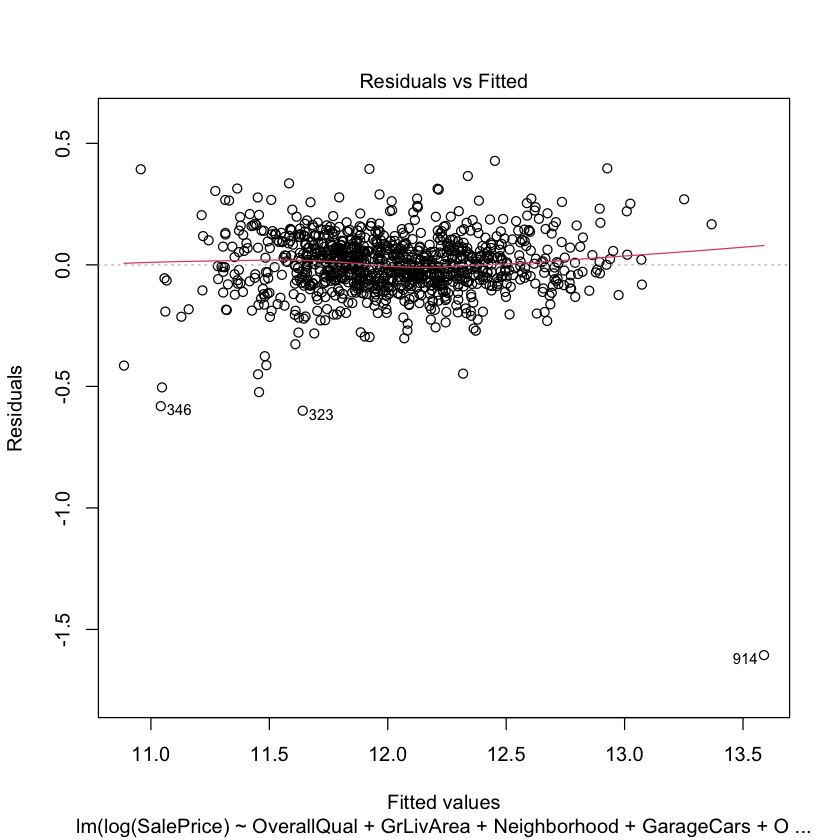

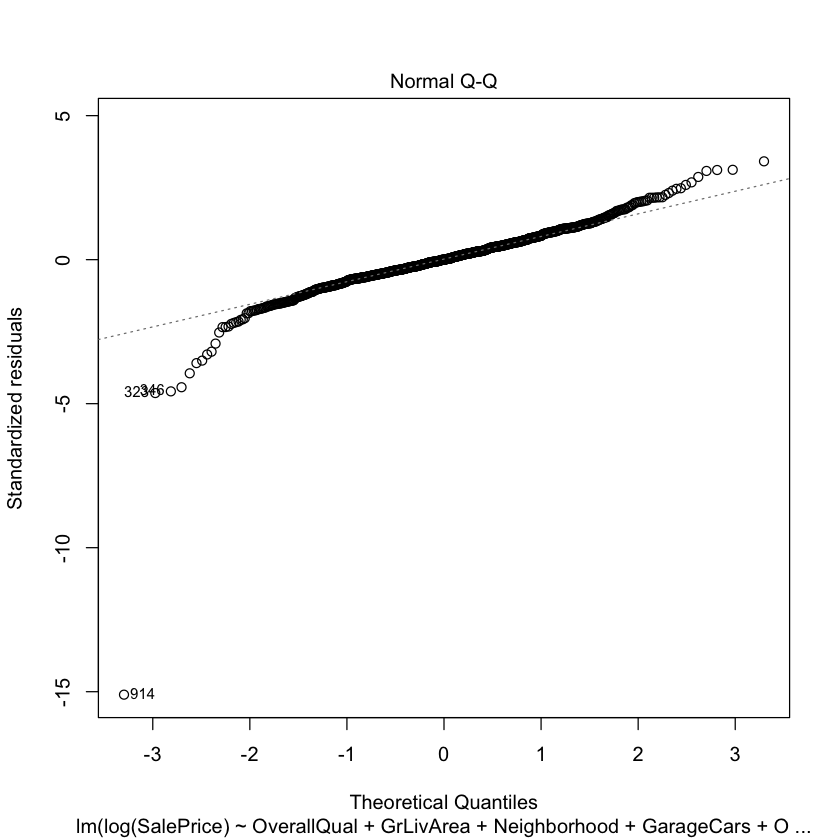

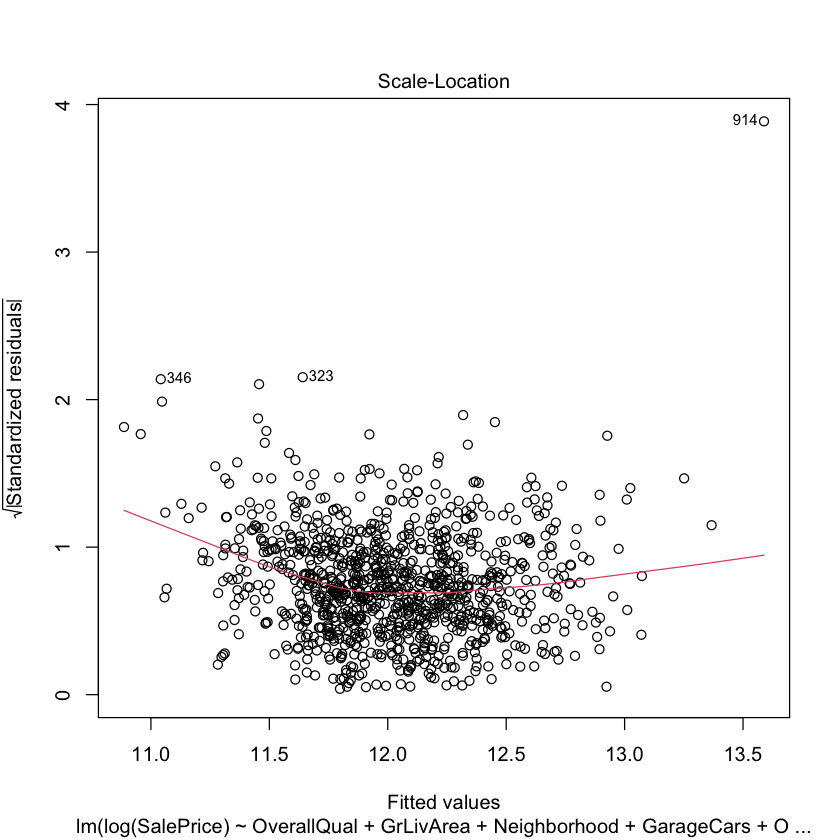

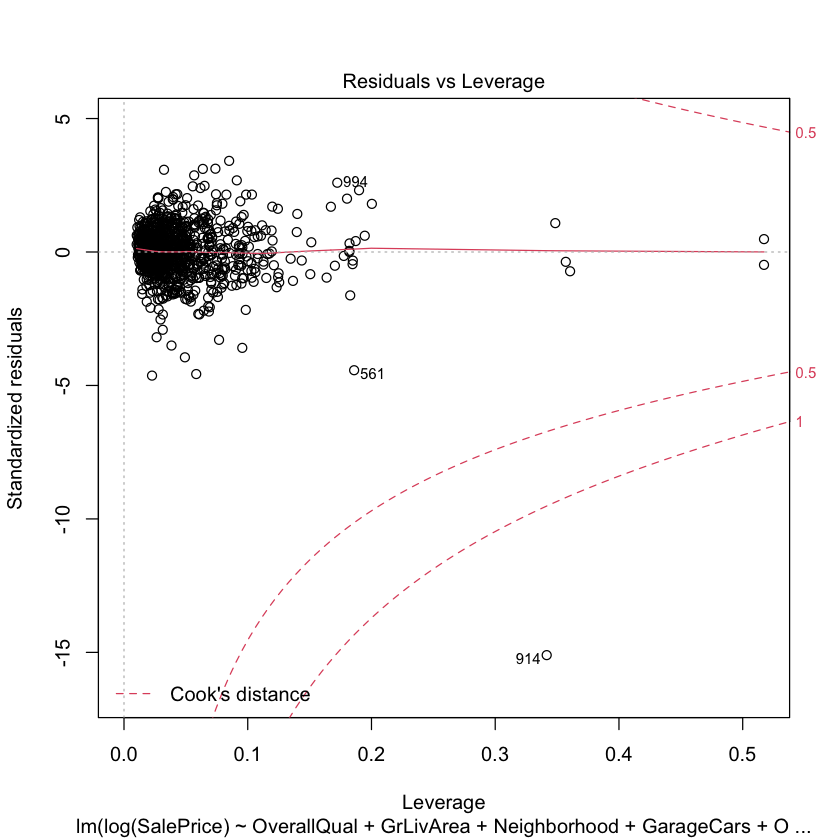

In [88]:
plot(fwdBIC.base)

In [89]:
summary(fwdBIC.base)


Call:
lm(formula = log(SalePrice) ~ OverallQual + GrLivArea + Neighborhood + 
    GarageCars + OverallCond + YearBuilt + BsmtFullBath + BldgType + 
    CentralAir + ScreenPorch + FullBath + TotalBsmtSF + Fireplaces + 
    WoodDeckSF + SaleCondition + LotFrontage, data = train_split)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.60564 -0.06431 -0.00037  0.07050  0.42786 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.445e+00  6.683e-01   8.147 1.14e-15 ***
OverallQual           6.940e-02  5.563e-03  12.475  < 2e-16 ***
GrLivArea             2.125e-04  1.407e-05  15.106  < 2e-16 ***
NeighborhoodBlueste  -1.353e-01  1.028e-01  -1.316  0.18840    
NeighborhoodBrDale   -1.165e-01  6.463e-02  -1.802  0.07188 .  
NeighborhoodBrkSide  -1.893e-02  5.397e-02  -0.351  0.72583    
NeighborhoodClearCr   8.488e-02  5.615e-02   1.512  0.13093    
NeighborhoodCollgCr  -4.574e-03  4.651e-02  -0.098  0.92168    
NeighborhoodCrawfor 

In [90]:
# Prediction Summary for Stepwise Base Model - Train Set
train.predict_sw.base <- as.matrix(exp(predict(fwdBIC.base, newdata=train_split)))
sw.base.model_trainresult <- as.data.frame(train.predict_sw.base)
names(sw.base.model_trainresult)[names(sw.base.model_trainresult) == 'V1'] <- 'train_predict'
sw.base.model_trainresult$train_actual = train_split$SalePrice
sw.base.model_trainresult$train_diff = (sw.base.model_trainresult$train_predict - sw.base.model_trainresult$train_actual)/sw.base.model_trainresult$train_actual
head(sw.base.model_trainresult)
signif(mean(sw.base.model_trainresult$train_diff^2), digits=3)

,train_predict,train_actual,train_diff
,<dbl>,<int>,<dbl>
1,208607.7,208500,0.0005164869
2,208639.0,181500,0.1495261893
3,218068.6,223500,-0.0243015341
4,173876.9,140000,0.2419776432
5,305406.6,250000,0.2216263561
6,149428.7,143000,0.0449556113


[1] 0.0306

In [91]:
# Prediction Summary for Stepwise Base Model - Test Set
test.predict_sw.base <- as.matrix(exp(predict(fwdBIC.base, newdata=test_split)))
sw.base.model_testresult <- as.data.frame(test.predict_sw.base)
names(sw.base.model_testresult)[names(sw.base.model_testresult) == 'V1'] <- 'test_predict'
sw.base.model_testresult$test_actual = test_split$SalePrice
sw.base.model_testresult$test_diff = (sw.base.model_testresult$test_predict - sw.base.model_testresult$test_actual)/sw.base.model_testresult$test_actual
head(sw.base.model_testresult)
signif(mean(sw.base.model_testresult$test_diff^2), digits=3)

,test_predict,test_actual,test_diff
,<dbl>,<int>,<dbl>
1,263433.5,307000,-0.14191051
2,409599.6,345000,0.18724516
3,223386.0,279500,-0.20076558
4,143274.9,157000,-0.08742088
5,349939.6,325300,0.07574413
6,235310.0,230000,0.02308688


[1] 0.0335

In [92]:
BIC.base = extractAIC(fwdBIC.base, k=log(n))[2]
signif(BIC.base, digits=6)

[1] -3872.63

In [93]:
# Calculate Model Error - Train Set
errorBIC_SWbasetrain <- predict(fwdBIC.base, newdata=train_split)-log(train_split$SalePrice)
errorBIC_SWbasetrain=mean(errorBIC_SWbasetrain^2)
signif(errorBIC_SWbasetrain, digits=3)

[1] 0.0164

In [94]:
# Calculate Model Error - Test Set
errorBIC_SWbasetest <- predict(fwdBIC.base, newdata=test_split)-log(test_split$SalePrice)
errorBIC_SWbasetest = mean(errorBIC_SWbasetest^2)
signif(errorBIC_SWbasetest, digits=3)

[1] 0.0212

## STEPWISE REGRESSION MODEL (FULL - WITH ALL POSIBLE INTERCATIONS)

In [95]:
# Build a model with all posible interactions
full_interact.house.rate <- lm(log(SalePrice) ~ . + .^2, data=train_split)

In [97]:
# Forward Stepwise Regression
# fwdBIC.interact <- step(base.house.rate, scope=formula(full_interact.house.rate),direction="forward", k=log(n))

Warning message:
“not plotting observations with leverage one:
  466”


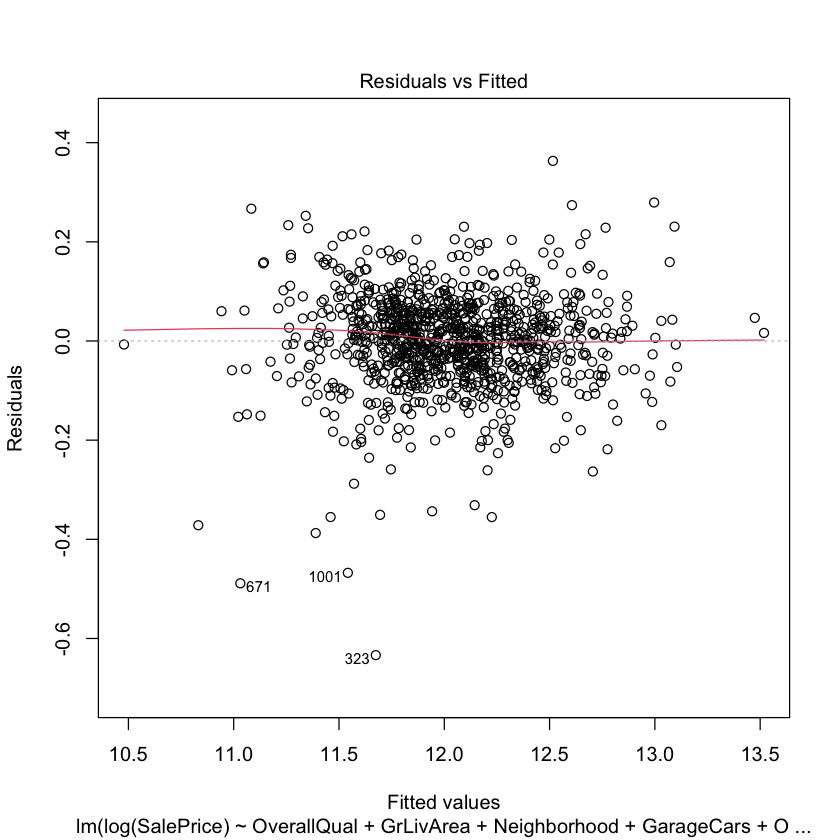

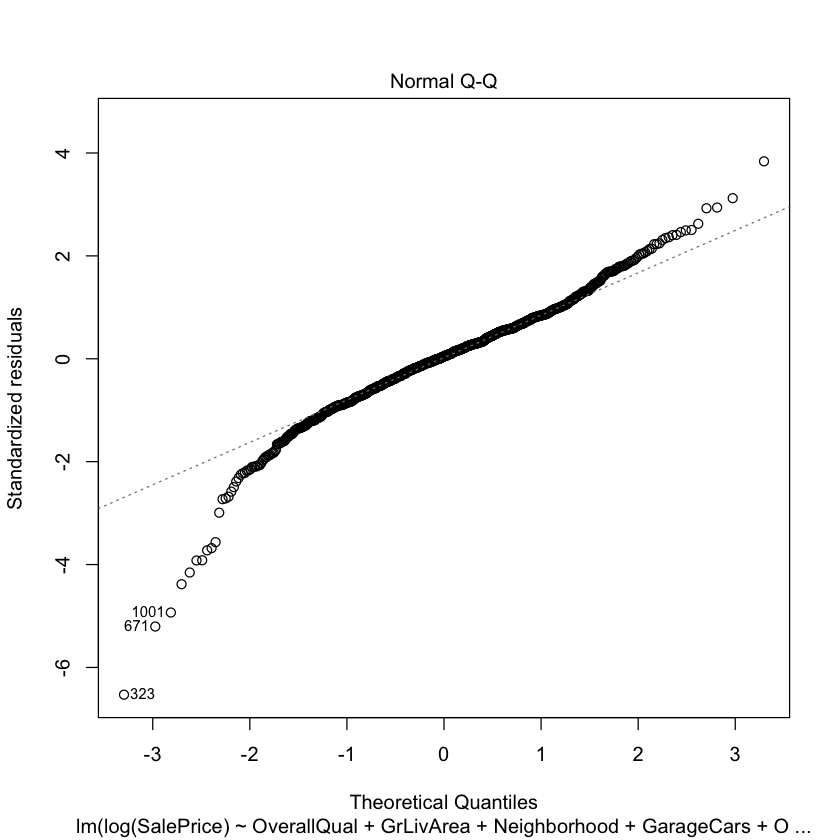

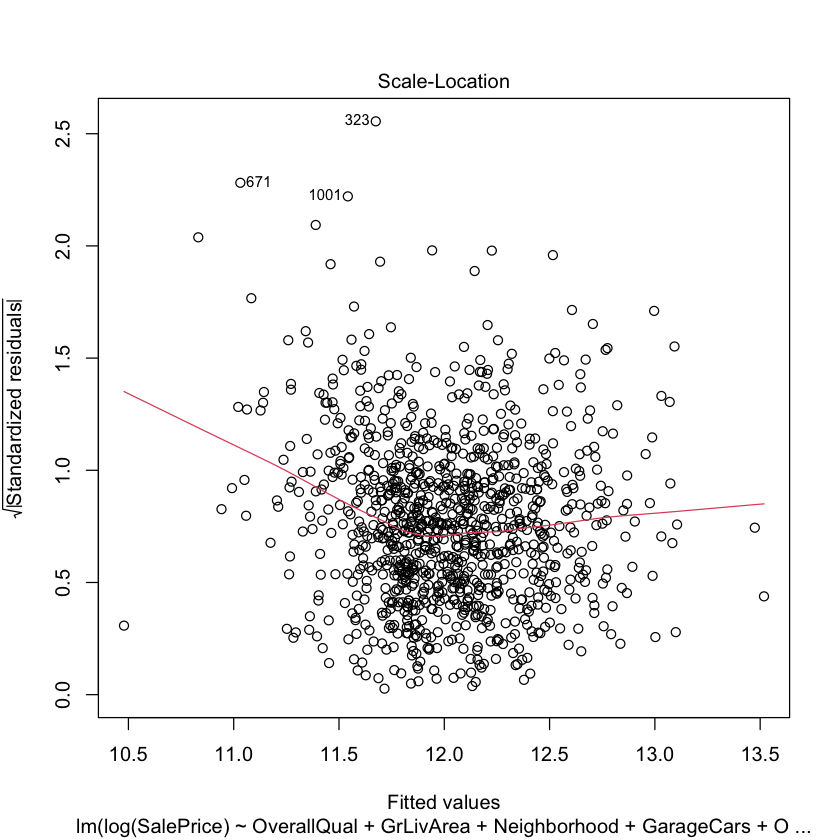

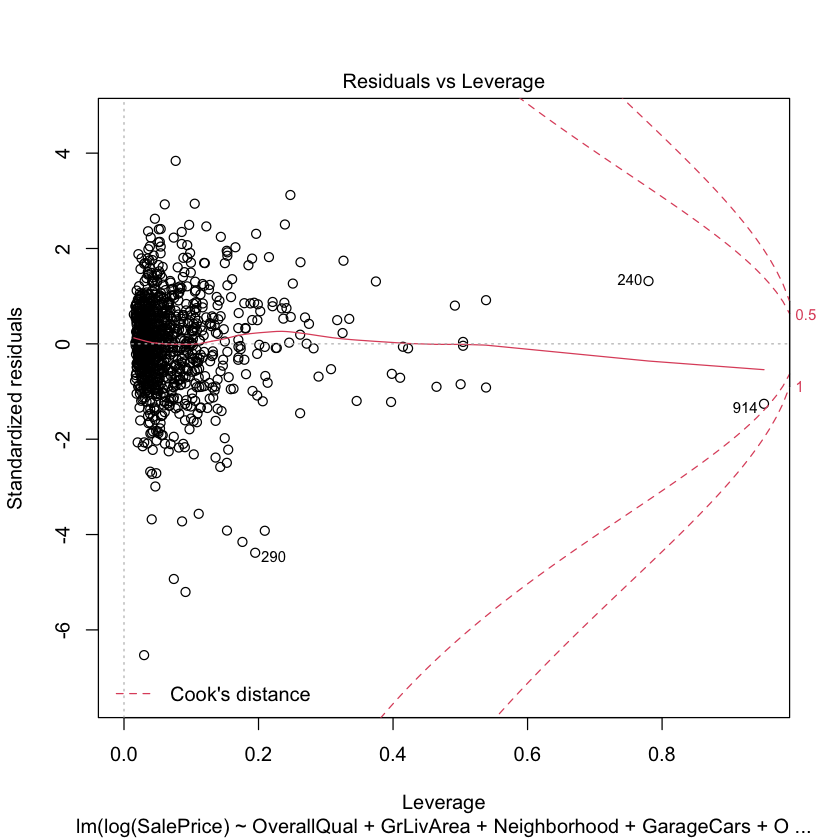

In [98]:
plot(fwdBIC.interact)

In [99]:
swfull.model_sum <- left_join(tidy(fwdBIC.interact, quick = TRUE),
                tidy(fwdBIC.interact, quick = FALSE),
                by = c("term", "estimate")) # includes Dec, se ...
swfull.model_sum

term,estimate,std.error.x,statistic.x,p.value.x,std.error.y,statistic.y,p.value.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),16.538271673,4.685494e+00,3.52967546,4.361338e-04,4.685494e+00,3.52967546,4.361338e-04
OverallQual,0.031389848,2.222471e-02,1.41238534,1.581658e-01,2.222471e-02,1.41238534,1.581658e-01
GrLivArea,0.000341655,3.728685e-05,9.16288164,3.067751e-19,3.728685e-05,9.16288164,3.067751e-19
NeighborhoodBlueste,-0.065520465,7.948967e-02,-0.82426388,4.099976e-01,7.948967e-02,-0.82426388,4.099976e-01
NeighborhoodBrDale,-0.030128592,4.986669e-02,-0.60418266,5.458672e-01,4.986669e-02,-0.60418266,5.458672e-01
NeighborhoodBrkSide,0.110644670,4.181433e-02,2.64609438,8.278030e-03,4.181433e-02,2.64609438,8.278030e-03
NeighborhoodClearCr,0.076191342,4.443887e-02,1.71452025,8.676110e-02,4.443887e-02,1.71452025,8.676110e-02
NeighborhoodCollgCr,0.009629266,3.367696e-02,0.28593038,7.749941e-01,3.367696e-02,0.28593038,7.749941e-01
NeighborhoodCrawfor,0.155076631,4.013024e-02,3.86433351,1.189987e-04,4.013024e-02,3.86433351,1.189987e-04


In [100]:
# write.csv(swfull.model_sum, file = "data/swfull_sum.csv", fileEncoding = "UTF-8")

In [101]:
summary(fwdBIC.interact)


Call:
lm(formula = log(SalePrice) ~ OverallQual + GrLivArea + Neighborhood + 
    GarageCars + OverallCond + YearBuilt + BsmtFullBath + TotalBsmtSF + 
    BsmtUnfSF + MSZoning + SaleCondition + CentralAir + Fireplaces + 
    LotArea + ScreenPorch + Functional + YearRemodAdd + KitchenAbvGr + 
    GarageFinish + GrLivArea:BsmtFullBath + GrLivArea:TotalBsmtSF + 
    OverallQual:TotalBsmtSF + OverallQual:GrLivArea + TotalBsmtSF:LotArea + 
    CentralAir:YearRemodAdd + OverallQual:LotArea + GarageCars:KitchenAbvGr + 
    YearBuilt:MSZoning + GrLivArea:LotArea + BsmtFullBath:Fireplaces + 
    OverallQual:KitchenAbvGr + OverallCond:YearBuilt + BsmtUnfSF:CentralAir + 
    CentralAir:LotArea + BsmtFullBath:TotalBsmtSF, data = train_split)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63357 -0.05031  0.00420  0.05598  0.36329 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.654e+01  4.685e+00   3.530 0.000436 ***
Over

In [102]:
# Prediction Summary for Stepwise Base Model - Train Set
train.predict_sw.full <- as.matrix(exp(predict(fwdBIC.interact, newdata=train_split)))
sw.full.model_trainresult <- as.data.frame(train.predict_sw.full)
names(sw.full.model_trainresult)[names(sw.full.model_trainresult) == 'V1'] <- 'train_predict'
sw.full.model_trainresult$train_actual = train_split$SalePrice
sw.full.model_trainresult$train_diff = (sw.full.model_trainresult$train_predict - sw.full.model_trainresult$train_actual)/sw.full.model_trainresult$train_actual
head(sw.full.model_trainresult)
signif(mean(sw.full.model_trainresult$train_diff^2), digits=3)

,train_predict,train_actual,train_diff
,<dbl>,<int>,<dbl>
1,209751.2,208500,0.006001046
2,196994.7,181500,0.085370243
3,214810.4,223500,-0.038879486
4,157581.6,140000,0.125582834
5,291372.4,250000,0.165489621
6,163541.7,143000,0.143648131


[1] 0.0101

In [103]:
# Prediction Summary for Stepwise Base Model - Test Set
test.predict_sw.full <- as.matrix(exp(predict(fwdBIC.interact, newdata=test_split)))
sw.full.model_testresult <- as.data.frame(test.predict_sw.full)
names(sw.full.model_testresult)[names(sw.full.model_testresult) == 'V1'] <- 'test_predict'
sw.full.model_testresult$test_actual = test_split$SalePrice
sw.full.model_testresult$test_diff = (sw.full.model_testresult$test_predict - sw.full.model_testresult$test_actual)/sw.full.model_testresult$test_actual
head(sw.full.model_testresult)
signif(mean(sw.full.model_testresult$test_diff^2), digits=3)

,test_predict,test_actual,test_diff
,<dbl>,<int>,<dbl>
1,269905.0,307000,-0.12083067
2,365838.1,345000,0.06040034
3,227910.1,279500,-0.18457939
4,147914.5,157000,-0.05786911
5,316367.9,325300,-0.02745819
6,245820.4,230000,0.06878433


[1] 0.0288

In [104]:
BIC.interact = extractAIC(fwdBIC.interact, k=log(n))[2]
signif(BIC.interact, digits=6)

[1] -4284.73

In [105]:
# Calculate Model Error - Train Set
errorBIC_SWfulltrain <- predict(fwdBIC.interact, newdata=train_split)-log(train_split$SalePrice)
errorBIC_SWfulltrain=mean(errorBIC_SWfulltrain^2)
signif(errorBIC_SWfulltrain, digits=3)

[1] 0.00898

## RANDOM FOREST MODEL

In [106]:
# Default RF model
rf.model <- randomForest(
  formula = log(SalePrice) ~ .,
  data    = train_split
)

rf.model


Call:
 randomForest(formula = log(SalePrice) ~ ., data = train_split) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 24

          Mean of squared residuals: 0.0194614
                    % Var explained: 87.79

In [107]:
# getTree(rf.model, 1, labelVar=TRUE)

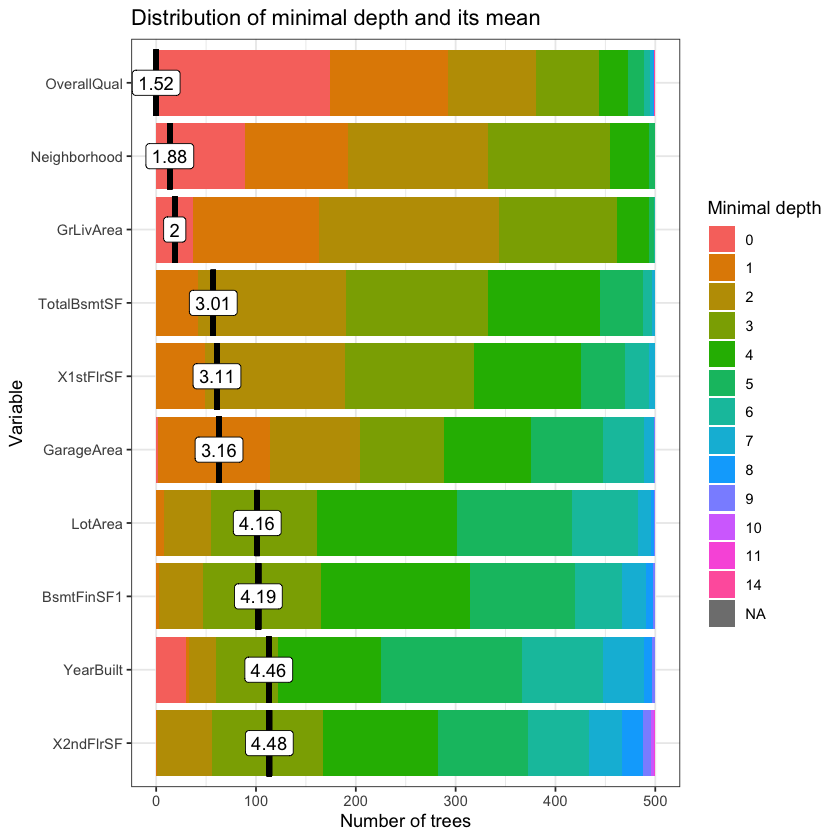

In [108]:
plot_min_depth_distribution(rf.model)

In [109]:
# plot_min_depth_interactions(rf.model)
# explain_forest(rf.model, interactions = TRUE, data = train_split)

In [110]:
# Prediction Summary for Random Forest Model - Test Set
test.predict_rf <- as.matrix(exp(predict(rf.model, newdata=test_split)))
rf.model_testresult <- as.data.frame(test.predict_rf)
names(rf.model_testresult)[names(rf.model_testresult) == 'V1'] <- 'test_predict'
rf.model_testresult$test_actual = test_split$SalePrice
rf.model_testresult$test_diff = (rf.model_testresult$test_predict - rf.model_testresult$test_actual)/rf.model_testresult$test_actual
head(rf.model_testresult)
signif(mean(rf.model_testresult$test_diff^2), digits=3)

,test_predict,test_actual,test_diff
,<dbl>,<int>,<dbl>
1,281904.9,307000,-0.08174311
2,369313.1,345000,0.07047289
3,225339.9,279500,-0.19377500
4,150361.9,157000,-0.04228066
5,331796.7,325300,0.01997153
6,243018.0,230000,0.05659986


[1] 0.0282

In [111]:
# Prediction Summary for Random Forest Model - Train Set
train.predict_rf <- as.matrix(exp(predict(rf.model, newdata=train_split)))
rf.model_trainresult <- as.data.frame(train.predict_rf)
names(rf.model_trainresult)[names(rf.model_trainresult) == 'V1'] <- 'train_predict'
rf.model_trainresult$train_actual = train_split$SalePrice
rf.model_trainresult$train_diff = (rf.model_trainresult$train_predict - rf.model_trainresult$train_actual)/rf.model_trainresult$train_actual
head(rf.model_trainresult)
signif(mean(rf.model_trainresult$train_diff^2), digits=3)

,train_predict,train_actual,train_diff
,<dbl>,<int>,<dbl>
1,208129.9,208500,-0.001775265
2,179030.9,181500,-0.013604092
3,221626.6,223500,-0.008381994
4,158655.7,140000,0.133254982
5,269312.7,250000,0.077250871
6,145464.7,143000,0.017235613


[1] 0.00364

## MODELS OUTPUT SUMMARY

In [112]:
## Comparing the results
BIC.merge <- c(BIC.base, BIC.interact, BIC.lasso, BIC.manual)
signif(BIC.merge, digits=6)
## Model probabilities
eBIC <- exp(-0.5*(BIC.merge-min(BIC.merge)))
probs <- eBIC/sum(eBIC)
round(probs, 5)

[1] -3872.63 -4284.73 21451.30 21555.40

[1] 0 1 0 0

In [113]:
## Out of sample prediction
# errorBIC_base <- predict(fwdBIC.base, newdata=test)-test$SalePrice
# errorBIC_intreact <- predict(fwdBIC.base.interact, newdata=test)-test$SalePrice
# errorBIC_lasso <- predict(post.lasso, newdata=test)-test$SalePrice
# errorBIC_manual <- predict(manual.model, newdata=test)-test$SalePrice

error_result = c(errorBIC_base=errorBIC_SWbasetest, 
           errorBIC_interact=errorBIC_SWfulltrain,
           errorBIC_lasso=errorBIC_lassotest,
           errorBIC_manual=errorBIC_manualtest
          )
signif(error_result, digits=5)

errorBIC_base errorBIC_interact    errorBIC_lasso   errorBIC_manual 
        0.0211790         0.0089837         0.0286240         0.0350590

In [114]:
# Create Summary Test Table
test_summary <- as.data.frame(test_split$SalePrice)
names(test_summary)[names(test_summary) == 'test_split$SalePrice'] <- 'Actual_Test'
test_summary$Predict_Lasso <- lasso.model_testresult$test_predict
test_summary$Predict_Manual <- manual.model_testresult$test_predict
test_summary$Predict_SWbase <- sw.base.model_testresult$test_predict
test_summary$Predict_SWfull <- sw.full.model_testresult$test_predict
test_summary$Predict_RandForest <- rf.model_testresult$test_predict
head(test_summary)

,Actual_Test,Predict_Lasso,Predict_Manual,Predict_SWbase,Predict_SWfull,Predict_RandForest
,<int>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>
1,307000,281874.8,240778.9,263433.5,269905.0,281904.9
2,345000,391080.4,354216.8,409599.6,365838.1,369313.1
3,279500,230253.2,220682.8,223386.0,227910.1,225339.9
4,157000,150406.0,142653.6,143274.9,147914.5,150361.9
5,325300,352123.9,367954.6,349939.6,316367.9,331796.7
6,230000,215167.4,226007.9,235310.0,245820.4,243018.0


In [115]:
# Create Summary Train Table
train_summary <- as.data.frame(train_split$SalePrice)
names(train_summary)[names(train_summary) == 'train_split$SalePrice'] <- 'Actual_Train'
train_summary$Predict_Lasso <- lasso.model_trainresult$train_predict
train_summary$Predict_Manual <- manual.model_trainresult$train_predict
train_summary$Predict_SWbase <- sw.base.model_trainresult$train_predict
train_summary$Predict_SWfull <- sw.full.model_trainresult$train_predict
train_summary$Predict_RandForest <- rf.model_trainresult$train_predict
head(train_summary)

,Actual_Train,Predict_Lasso,Predict_Manual,Predict_SWbase,Predict_SWfull,Predict_RandForest
,<int>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>
1,208500,206537.5,218823.0,208607.7,209751.2,208129.9
2,181500,201220.9,210146.2,208639.0,196994.7,179030.9
3,223500,211639.8,230315.0,218068.6,214810.4,221626.6
4,140000,173485.6,197138.0,173876.9,157581.6,158655.7
5,250000,303027.3,320088.8,305406.6,291372.4,269312.7
6,143000,154145.0,182127.5,149428.7,163541.7,145464.7


In [116]:
# write.csv(test_summary, file = "data/test_summary.csv", fileEncoding = "UTF-8")
# write.csv(train_summary, file = "data/train_summary.csv", fileEncoding = "UTF-8")